
Training Simple GCN...
Epoch 0 | Loss: 1.2326
Epoch 10 | Loss: 0.1011
Epoch 20 | Loss: 0.0780
Epoch 30 | Loss: 0.0732
Epoch 40 | Loss: 0.0670
Epoch 50 | Loss: 0.0591
Epoch 60 | Loss: 0.0505
Epoch 70 | Loss: 0.0534
Epoch 80 | Loss: 0.0434
Epoch 90 | Loss: 0.0435


<Figure size 800x600 with 0 Axes>

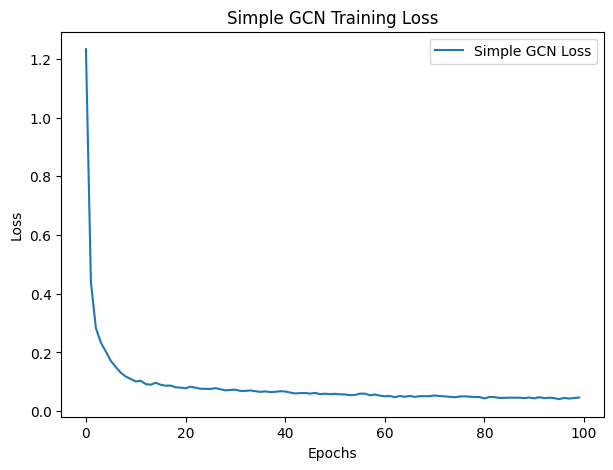


Simple GCN Train Evaluation:
Precision: 0.9859
Recall: 0.9859
F1 Score: 0.9859
AUC-ROC Score: 0.9991
Accuracy Score: 0.9859
Confusion Matrix:
[[544   8]
 [  8 576]]


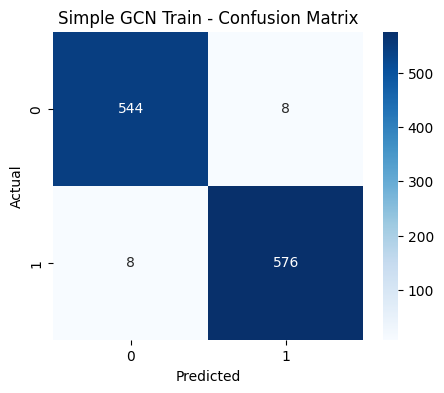


Simple GCN Test Evaluation:
Precision: 0.9466
Recall: 0.9610
F1 Score: 0.9515
AUC-ROC Score: 0.9972
Accuracy Score: 0.9528
Confusion Matrix:
[[260  22]
 [  0 184]]


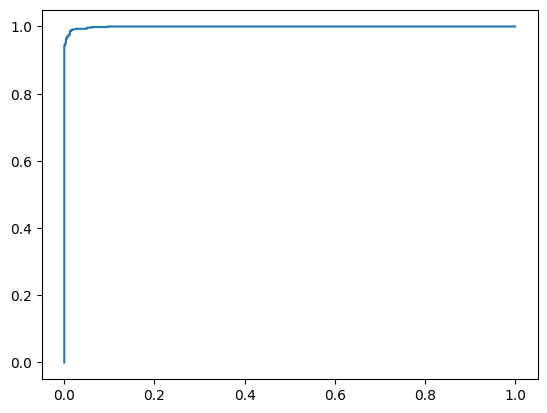

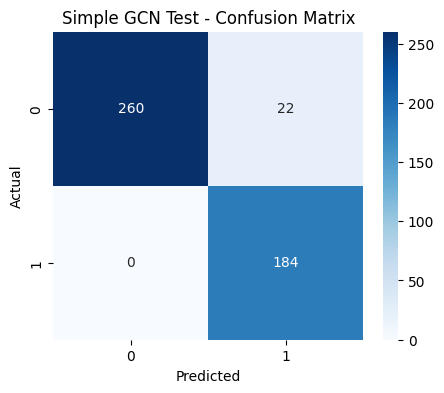


Training GCN 5 Layer...
Epoch 0 | Loss: 1.1856
Epoch 10 | Loss: 0.0976
Epoch 20 | Loss: 0.0852
Epoch 30 | Loss: 0.0812
Epoch 40 | Loss: 0.0743
Epoch 50 | Loss: 0.0612
Epoch 60 | Loss: 0.0598
Epoch 70 | Loss: 0.0539
Epoch 80 | Loss: 0.0548
Epoch 90 | Loss: 0.0482


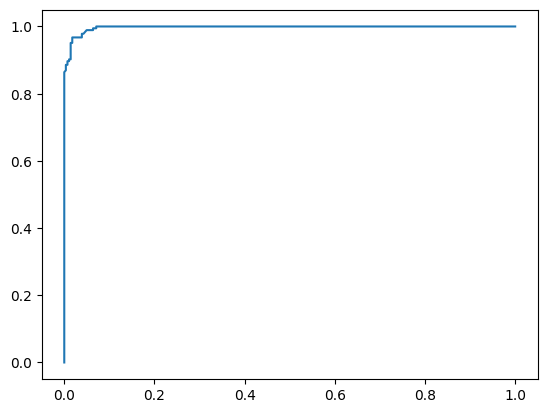

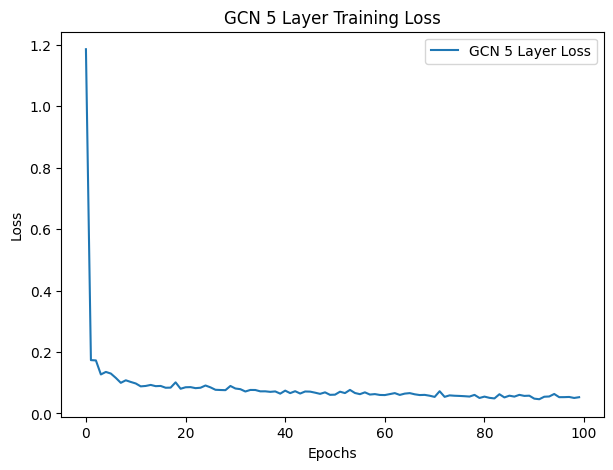


GCN 5 Layer Train Evaluation:
Precision: 0.9843
Recall: 0.9840
F1 Score: 0.9841
AUC-ROC Score: 0.9993
Accuracy Score: 0.9842
Confusion Matrix:
[[541  11]
 [  7 577]]


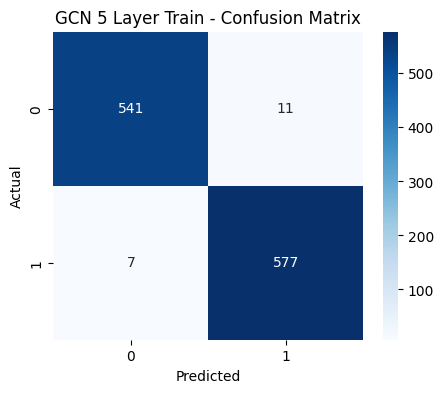


GCN 5 Layer Test Evaluation:
Precision: 0.9340
Recall: 0.9504
F1 Score: 0.9385
AUC-ROC Score: 0.9947
Accuracy Score: 0.9399
Confusion Matrix:
[[254  28]
 [  0 184]]


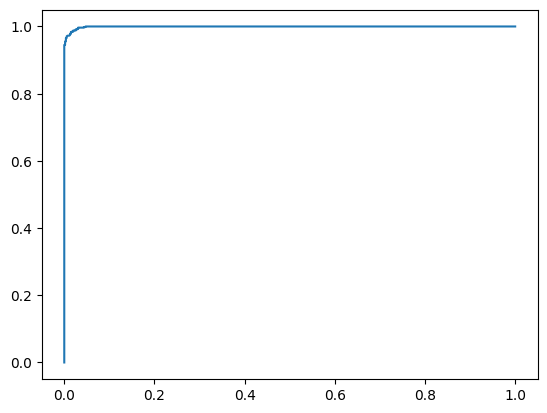

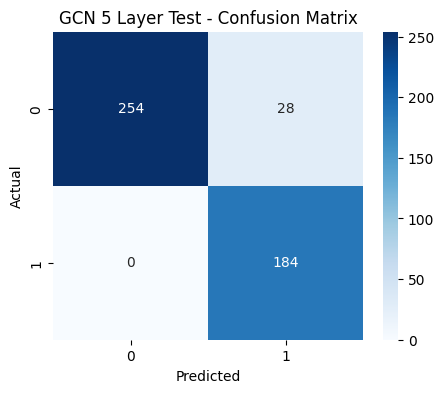


Training GCN 7 Layer...
Epoch 0 | Loss: 0.8081
Epoch 10 | Loss: 0.1214
Epoch 20 | Loss: 0.1078
Epoch 30 | Loss: 0.0994
Epoch 40 | Loss: 0.0914
Epoch 50 | Loss: 0.0824
Epoch 60 | Loss: 0.0760
Epoch 70 | Loss: 0.0782
Epoch 80 | Loss: 0.0693
Epoch 90 | Loss: 0.0697


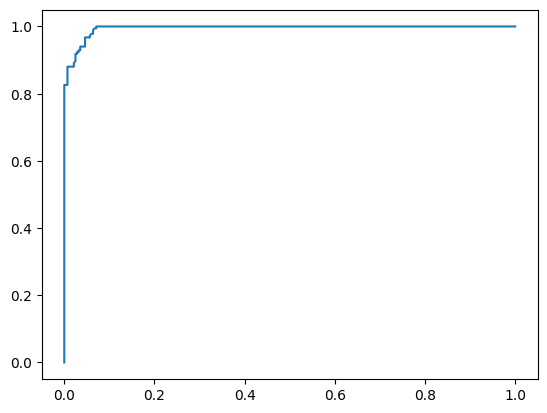

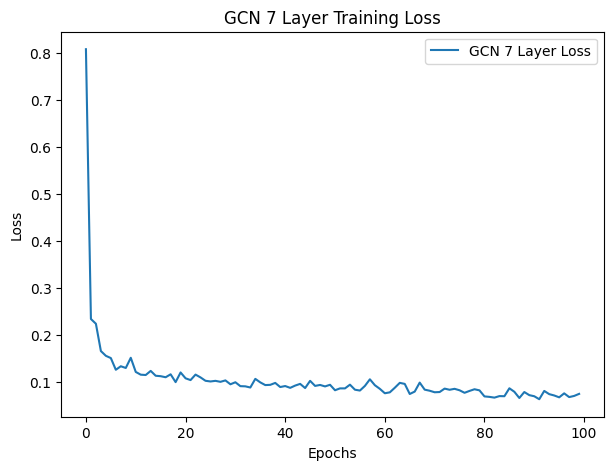


GCN 7 Layer Train Evaluation:
Precision: 0.9791
Recall: 0.9787
F1 Score: 0.9788
AUC-ROC Score: 0.9985
Accuracy Score: 0.9789
Confusion Matrix:
[[536  16]
 [  8 576]]


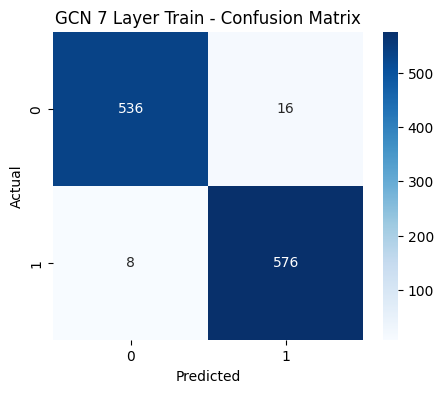


GCN 7 Layer Test Evaluation:
Precision: 0.9279
Recall: 0.9450
F1 Score: 0.9321
AUC-ROC Score: 0.9954
Accuracy Score: 0.9335
Confusion Matrix:
[[251  31]
 [  0 184]]


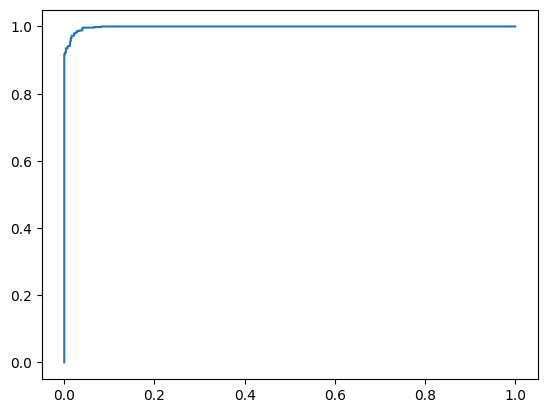

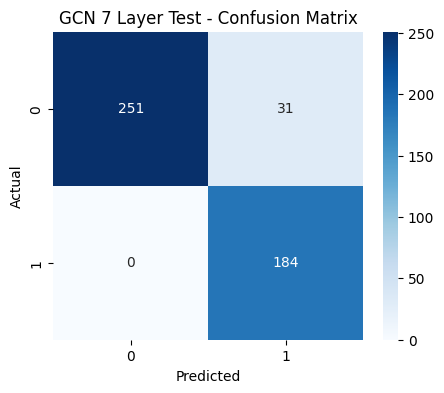


Training DisenGCN...
Epoch 0 | Loss: 0.8341
Epoch 10 | Loss: 0.1124
Epoch 20 | Loss: 0.0909
Epoch 30 | Loss: 0.0773
Epoch 40 | Loss: 0.0768
Epoch 50 | Loss: 0.0632
Epoch 60 | Loss: 0.0669
Epoch 70 | Loss: 0.0578
Epoch 80 | Loss: 0.0567
Epoch 90 | Loss: 0.0567


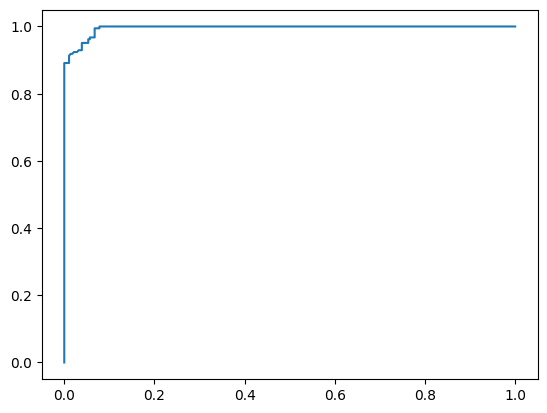

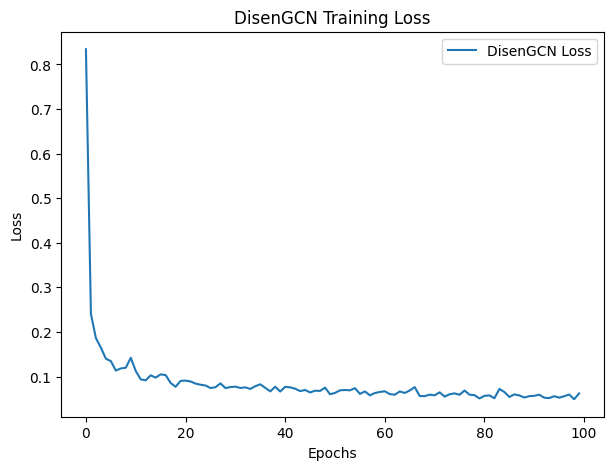


DisenGCN Train Evaluation:
Precision: 0.9814
Recall: 0.9816
F1 Score: 0.9815
AUC-ROC Score: 0.9991
Accuracy Score: 0.9815
Confusion Matrix:
[[544   8]
 [ 13 571]]


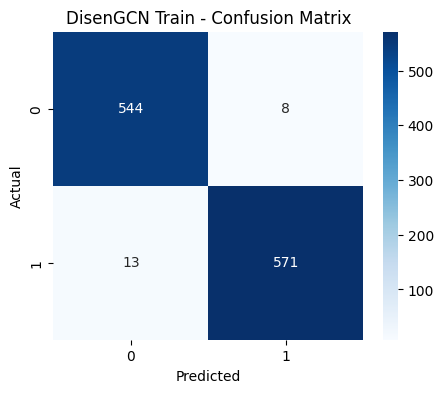


DisenGCN Test Evaluation:
Precision: 0.9340
Recall: 0.9504
F1 Score: 0.9385
AUC-ROC Score: 0.9988
Accuracy Score: 0.9399
Confusion Matrix:
[[254  28]
 [  0 184]]


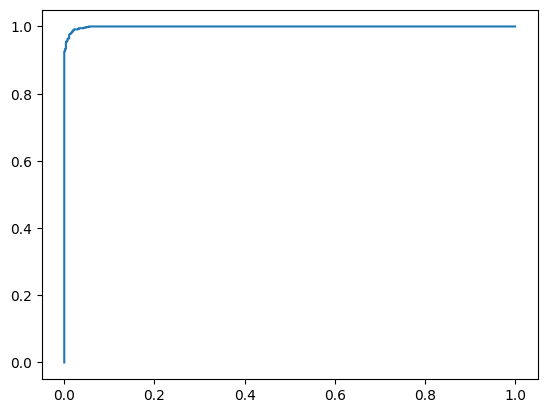

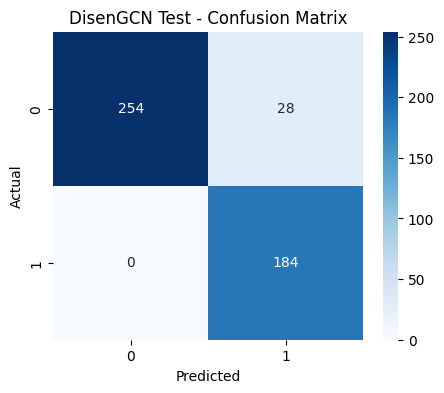

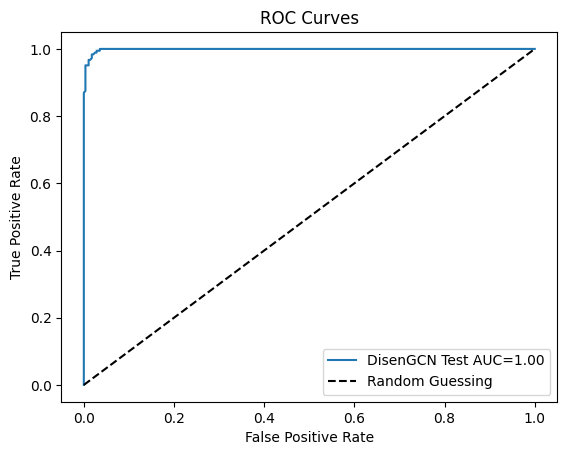


Models, Metrics, and Plots saved successfully!


In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load & Preprocess Data
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    df["label"] = df["label"].map({"UP": 0, "DOWN": 1})
    X = df.drop(columns=["label"]).values
    y = df["label"].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y, dtype=torch.long), scaler

X_train, y_train, scaler = load_data("train.csv")
X_test, y_test, _ = load_data("test.csv")

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Create Graph with KNN
def create_graph(X, y, k=5):
    A = kneighbors_graph(X.cpu().numpy(), k, mode="connectivity", include_self=True)
    edge_index = torch.tensor(np.array(A.nonzero()), dtype=torch.long).to(device)
    return Data(x=X, edge_index=edge_index, y=y)

train_graph = create_graph(X_train, y_train)
test_graph = create_graph(X_test, y_test)

# Define GCN Models
class SimpleGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(F.relu(x))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN_5Layer(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=2, dropout=0.4):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim // 2)
        self.bn3 = torch.nn.BatchNorm1d(hidden_dim // 2)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv4 = GCNConv(hidden_dim // 2, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(F.relu(x))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(F.relu(x))
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(F.relu(x))
        x = self.dropout(x)
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN_7Layer(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=2, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim // 2)
        self.bn4 = torch.nn.BatchNorm1d(hidden_dim // 2)
        self.conv5 = GCNConv(hidden_dim // 2, hidden_dim // 4)
        self.bn5 = torch.nn.BatchNorm1d(hidden_dim // 4)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv6 = GCNConv(hidden_dim // 4, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(F.relu(x))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(F.relu(x))
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(F.relu(x))
        x = self.dropout(x)
        x = self.conv4(x, edge_index)
        x = self.bn4(F.relu(x))
        x = self.dropout(x)
        x = self.conv5(x, edge_index)
        x = self.bn5(F.relu(x))
        x = self.dropout(x)
        x = self.conv6(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define DisenGCN Model (Disentangled Graph Convolutional Network)
class DisenGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=2, dropout=0.4):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim // 2)
        self.bn3 = torch.nn.BatchNorm1d(hidden_dim // 2)
        self.conv4 = GCNConv(hidden_dim // 2, output_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Disentangled graph convolution operations
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(F.relu(x1))
        x1 = self.dropout(x1)

        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(F.relu(x2))
        x2 = self.dropout(x2)

        x3 = self.conv3(x2, edge_index)
        x3 = self.bn3(F.relu(x3))
        x3 = self.dropout(x3)

        x_out = self.conv4(x3, edge_index)
        return F.log_softmax(x_out, dim=1)

# Train & Evaluate Models
models = {
    "Simple GCN": SimpleGCN(input_dim=X_train.shape[1]).to(device),
    "GCN 5 Layer": GCN_5Layer(input_dim=X_train.shape[1]).to(device),
    "GCN 7 Layer": GCN_7Layer(input_dim=X_train.shape[1]).to(device),
    "DisenGCN": DisenGCN(input_dim=X_train.shape[1]).to(device),
}

# Train the Model & Track Loss
def train_model(model, data, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    return losses

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Evaluate the Model
def evaluate(model, data, label=""):
    model.eval()
    with torch.no_grad():
        pred = model(data).argmax(dim=1)
        prob = torch.exp(model(data))[:, 1].cpu().numpy()
    y_true = data.y.cpu().numpy()
    y_pred = pred.cpu().numpy()
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, prob)

    accuracy = accuracy_score(y_true, y_pred)

    print(f"\n{label} Evaluation:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"Accuracy Score: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, title=f"{label} - Confusion Matrix")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, prob)
    plt.plot(fpr, tpr, label=f"{label} AUC={auc_score:.2f}")

    return precision, recall, f1, cm, auc_score, accuracy

# Plotting setup
plt.figure(figsize=(8, 6))

# Train and Evaluate Models
for name, model in models.items():
    print(f"\nTraining {name}...")
    loss_curve = train_model(model, train_graph)

    # Plot Loss Curve
    plt.figure(figsize=(7,5))
    plt.plot(loss_curve, label=f"{name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{name} Training Loss")
    plt.legend()
    plt.show()

    evaluate(model, train_graph, f"{name} Train")
    evaluate(model, test_graph, f"{name} Test")

# Plot Random Guessing Line in ROC Curve
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Save Models and Scaler
for name, model in models.items():
    torch.save(model.state_dict(), f"./model/{name.lower().replace(' ', '_')}.pth")
with open("./model/input_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("\nModels, Metrics, and Plots saved successfully!")


In [29]:
final_models = {
    "3_layers_GCN": SimpleGCN,
    "5_layers_GCN": GCN_5Layer,
    "7_layers_GCN": GCN_7Layer,
    "DisenGCN": DisenGCN
}


In [30]:
import pickle

# Save all GCN models
with open("./model/all_GCN.pkl", "wb") as f:
    pickle.dump(final_models, f)

print("all_GCN.pkl saved successfully!")


all_GCN.pkl saved successfully!


In [31]:
with open("./model/all_GCN.pkl", "rb") as f:
    dp_models = pickle.load(f)

print("Loaded all GCN models:", dp_models.keys())


Loaded all GCN models: dict_keys(['3_layers_GCN', '5_layers_GCN', '7_layers_GCN', 'DisenGCN'])


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Evaluate the Model and add RMSE calculation
def evaluate(model, data, label=""):
    model.eval()
    with torch.no_grad():
        pred = model(data).argmax(dim=1)  # predicted labels
        prob = torch.exp(model(data))[:, 1].cpu().numpy()  # predicted probabilities for the positive class
    y_true = data.y.cpu().numpy()  # true labels
    y_pred = pred.cpu().numpy()

    # Calculate Accuracy and RMSE
    accuracy = accuracy_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # RMSE calculation

    # Calculate Precision, Recall, F1 Score, AUC, etc.
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, prob)

    print(f"\n{label} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"RMSE: {rmse:.4f}")  # Print RMSE
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, title=f"{label} - Confusion Matrix")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, prob)
    plt.plot(fpr, tpr, label=f"{label} AUC={auc_score:.2f}")

    return accuracy, rmse, precision, recall, f1, cm, auc_score


In [ ]:
# Initialize lists to store accuracy and RMSE values for DisenGCN
accuracy_list = []
rmse_list = []

# Train and Evaluate Models
for name, model in models.items():
    if name == "DisenGCN":  # Only for DisenGCN
        print(f"\nTraining {name}...")
        loss_curve = train_model(model, train_graph)

        # Plot Loss Curve
        plt.figure(figsize=(7,5))
        plt.plot(loss_curve, label=f"{name} Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"{name} Training Loss")
        plt.legend()
        plt.show()

        # Evaluate on Train and Test
        accuracy, rmse, precision, recall, f1, cm, auc_score = evaluate(model, train_graph, f"{name} Train")
        accuracy_list.append(accuracy)
        rmse_list.append(rmse)

        accuracy, rmse, precision, recall, f1, cm, auc_score = evaluate(model, test_graph, f"{name} Test")
        accuracy_list.append(accuracy)
        rmse_list.append(rmse)

# Plot Accuracy and RMSE for DisenGCN
plt.figure(figsize=(10,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(accuracy_list, label="Accuracy", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("DisenGCN Accuracy over Epochs")
plt.legend()

# RMSE plot
plt.subplot(1, 2, 2)
plt.plot(rmse_list, label="RMSE", color='red')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("DisenGCN RMSE over Epochs")
plt.legend()

plt.tight_layout()
plt.show()
